In [1]:
library(lme4)
options(rgl.useNULL=TRUE)
library(LMERConvenienceFunctions)

library(ggplot2)
options(jupyter.plot_mimetypes = 'image/png')
library(repr)
options(repr.plot.width=6, repr.plot.height=6)

library(car)
library(MASS)

library(vcd)

Loading required package: Matrix
Loading required package: grid


# Number of answers

In this notebook, we document our various steps taken to study the effect of the course of a session on the number of answers a comment receives. Note that we only do this on a sample of 1 mio. data points here.

In [50]:
data = read.csv("/home/psinger/Reddit-depletion/data/sample.csv", header=TRUE)

In [3]:
nrow(data)

[1] 1000000

## Data inspection

We start by getting a better feeling of our data. Note that num_answers represents count data.

We can limit our data to those sessions that have at least two comments.

In [5]:
idx = data$session_comments>1

In [6]:
data = data[idx,]

In [7]:
nrow(data)

[1] 667938

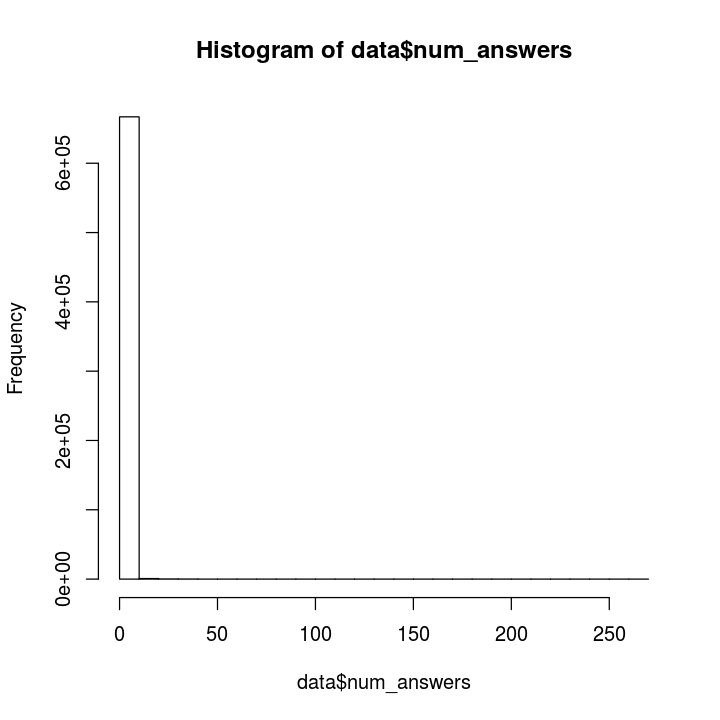

In [8]:
hist(data$num_answers)

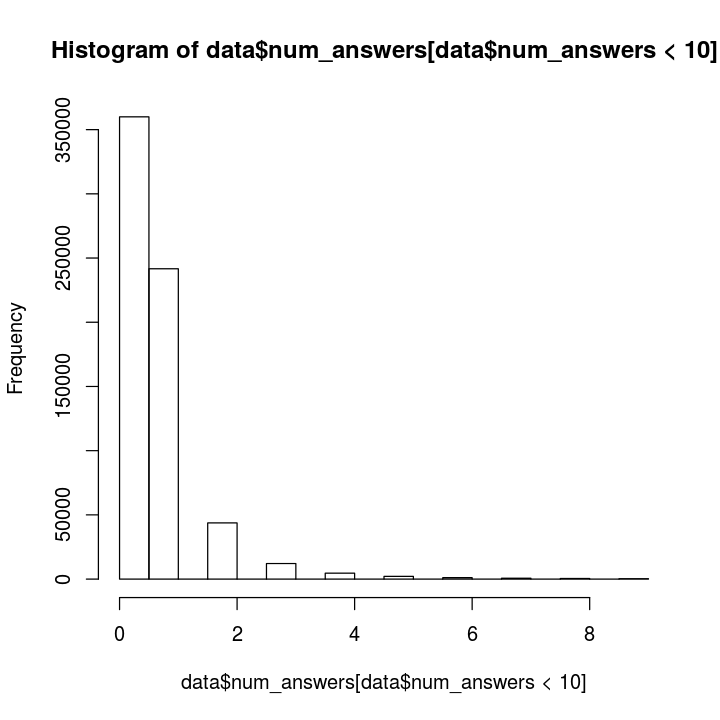

In [9]:
hist(data$num_answers[data$num_answers<10])

## Regression model

We use mixed-effects models where in the basic form (that we analyze in this notebook), we are interested in studying num_answers ~ 1 + session_index + session_comments + (1|author).

### Linear mixed-effects regression

Even though we cannot expect a simple linear mixed-effects regression to be an appropriate model for our count data, we start with it.

In [10]:
m_lmer = lmer(num_answers~1+session_index + session_comments+(1|author), data=data, REML=FALSE)

In [11]:
summary(m_lmer)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: num_answers ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2415021  2415078 -1207506  2415011   667933 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
 -6.066  -0.430  -0.386   0.237 179.957 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.07539  0.2746  
 Residual             2.10601  1.4512  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       0.6459621  0.0020832  310.08
session_index    -0.0027296  0.0002374  -11.50
session_comments  0.0019404  0.0001513   12.82

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.043       
sssn_cmmnts -0.195 -0.805

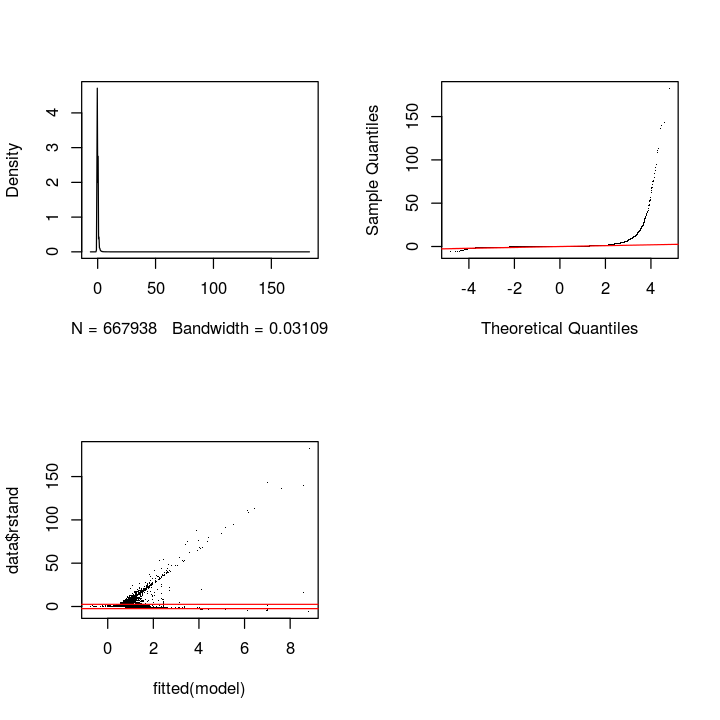

In [12]:
mcp.fnc(m_lmer)

What we can see in above plot is, that the residuals do not appear to be normally distributed and we can see clear heteroskedasticity. Thus, as expected, a linear model does not provide a good fit here.

### Linear mixed-effects regression (log-transform)

Next, let us take the log of the response variable and repeat a linear regression.

In [14]:
m_lmer_log = lmer(log1p(num_answers)~1+session_index+session_comments+(1|author), data=data, REML=FALSE)

In [15]:
summary(m_lmer_log)

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: log1p(num_answers) ~ 1 + session_index + session_comments + (1 |  
    author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
 831049.4  831106.5 -415519.7  831039.4    667933 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.3533 -0.8017 -0.6936  0.6914 11.3410 

Random effects:
 Groups   Name        Variance Std.Dev.
 author   (Intercept) 0.01127  0.1061  
 Residual             0.19295  0.4393  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error t value
(Intercept)       3.720e-01  6.501e-04   572.2
session_index    -9.962e-04  7.210e-05   -13.8
session_comments  8.469e-04  4.665e-05    18.2

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.043       
sssn_cmmnts -0.195 -0.792

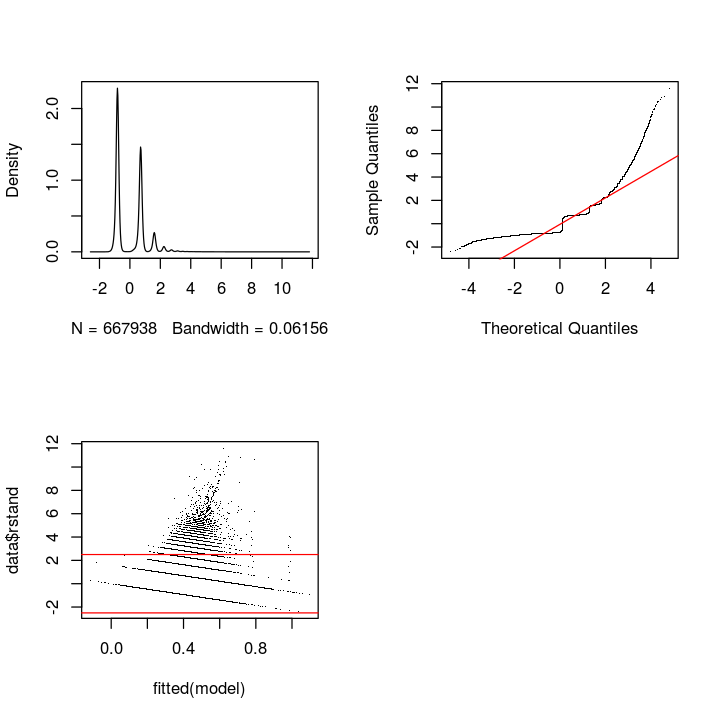

In [16]:
mcp.fnc(m_lmer_log)

That does not look satisfying at all. We should focus on generalized mixed-effects models to better model the count data.

### Poisson GLMER

Let us start with a Poisson GLMER, which is a main choice when working with count data.

In [17]:
m_poisson = glmer(num_answers~1+session_index+session_comments+(1|author),data=data,family=poisson())

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0143041 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

In [18]:
summary(m_poisson)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 1470676  1470722  -735334  1470668   667934 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.709 -0.670 -0.595  0.499 35.465 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3708   0.6089  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.6368798  0.0024965  -255.1   <2e-16 ***
session_index    -0.0035297  0.0001995   -17.7   <2e-16 ***
session_comments  0.0024990  0.0001213    20.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.084       
sssn_cmmnts -0.135 -0.692
convergence code: 0
Model failed t

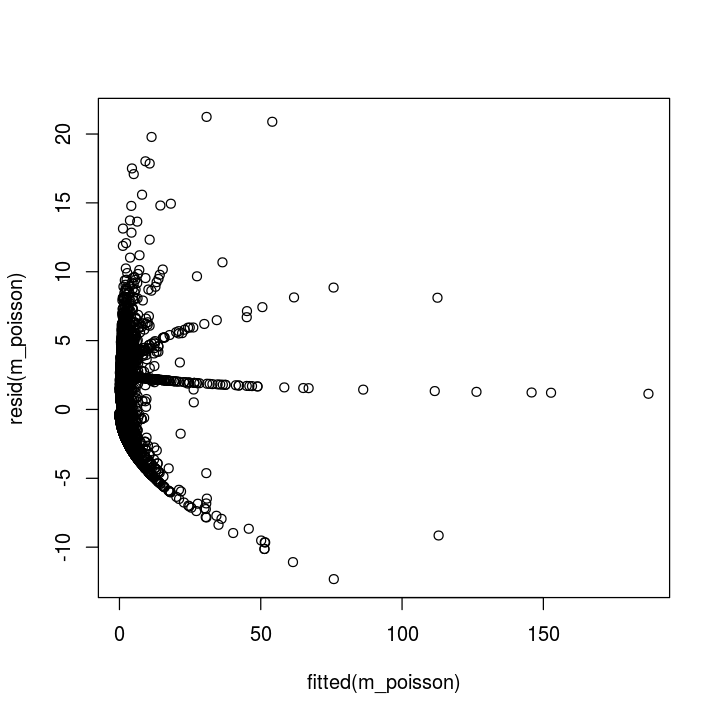

In [19]:
plot(fitted(m_poisson),resid(m_poisson))

The convergence message shows low magnitude and for such large data this might be a false positive as emphasized in the lme4 docu. 

The residual plots for generalized linear models are generally quite difficult to interpret as the residuals do not necessarily need to follow a normal distribution any longer. However, the fitted vs. residual plots shows a typical pattern for Poisson regression with curvilinear traces. What we can do though as a first step here, is to look at overdispersion (see http://glmm.wikidot.com/faq).

In [23]:
overdisp_fun <- function(model) {
  ## number of variance parameters in 
  ##   an n-by-n variance-covariance matrix
  vpars <- function(m) {
    nrow(m)*(nrow(m)+1)/2
  }
  model.df <- sum(sapply(VarCorr(model),vpars))+length(fixef(model))
  rdf <- nrow(model.frame(model))-model.df
  rp <- residuals(model,type="pearson")
  Pearson.chisq <- sum(rp^2)
  prat <- Pearson.chisq/rdf
  pval <- pchisq(Pearson.chisq, df=rdf, lower.tail=FALSE)
  c(chisq=Pearson.chisq,ratio=prat,rdf=rdf,p=pval)
}

In [24]:
overdisp_fun(m_poisson)

chisq        ratio          rdf            p 
5.917732e+05 8.859756e-01 6.679340e+05 1.000000e+00

It does not seem that we have any problem with overdispersion here.

Let us be sure and check it with the dispersion_glmer function from the blmeco packages. 

In [25]:
library("blmeco") 
dispersion_glmer(m_poisson)

[1] 1.020395

The value is between 0.75 and 1.4 which gives an indicator that there is no overdispersion problem.

What might be an issue for our model though, is the vast presence of zeros in our data. In order to tackle this issue, one can look at zero-inflated Poisson models. Unfortunately, these are only implemented in the MCMCglmm and glmmADMB packages which both utilize complex fitting methods that do not scale to large data and are thus, not useful for our large data case. 

To that end, we use a generic "implementation of the EM algorithm that alternates between fitting a GLMM with data that are weighted according to their zero probability, and fitting a binary FLM for the probability that a data point is zero"---for detailed reference please refer to https://groups.nceas.ucsb.edu/non-linear-modeling/projects/owls/WRITEUP/owls.pdf. 

In [26]:
source("owls_R_funs.R")

In [ ]:
m_poisson_zi = zipme(cformula=num_answers~1+session_index+session_comments+(1|author), zformula=z~1,data=data,cfamily=poisson())

In [30]:
summary(m_poisson_zi)

          Length Class    Mode   
zfit          30 glm      list   
cfit           1 glmerMod S4     
itr            1 -none-   numeric
deltainfo     20 -none-   numeric
z         667938 -none-   numeric

In [31]:
summary(m_poisson_zi$cfit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index + session_comments + (1 | author)
   Data: bydataw
Weights: (1 - z)

      AIC       BIC    logLik  deviance  df.resid 
1424279.1 1424324.8 -712135.6 1424271.1    667934 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.1025 -0.6608 -0.5904  0.4608 29.0451 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3645   0.6038  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.5884804  0.0024830 -237.01   <2e-16 ***
session_index    -0.0033664  0.0001994  -16.88   <2e-16 ***
session_comments  0.0023841  0.0001219   19.56   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.082       
sssn_cmmnts -0.136 -

Even though we see some convergence warnings (low magnitude, for each iteration), we can see is that the coefficients are very similar to the model fitted without zero-inflation. Comparing the BIC thoughs reveals a better fit in general for the ZIP.

Again, for completeness, we fit a negative binomial regression with quasi likelihood.

In [51]:
#just for initialization
init = glm.nb(num_answers~1+session_index+session_comments,data=data)

In [52]:
init$theta

[1] 1.499887

In [53]:
m_pql_nb = glmmPQL(num_answers~1+session_index, random = list(~1 | author), data = data, family = negative.binomial(theta=init$theta))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [54]:
summary(m_pql_nb)

Linear mixed-effects model fit by maximum likelihood
 Data: data 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | author
        (Intercept)  Residual
StdDev:   0.5501248 0.8571615

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects: num_answers ~ 1 + session_index 
                   Value    Std.Error     DF   t-value p-value
(Intercept)   -0.6128875 0.0017373560 509213 -352.7702  0.0000
session_index  0.0002797 0.0001374711 509213    2.0350  0.0419
 Correlation: 
              (Intr)
session_index -0.243

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-5.5554727 -0.6931326 -0.6459643  0.4986831 27.8492137 

Number of Observations: 1000000
Number of Groups: 490786 

Again, very similar results.

## Final model choice

Given our extensive analysis regarding the appropriate model for our data, we can conclude that all have very similar conclusions, namely that the session_index has a negative effect on num_answers. Probably, the most appropriate model would be the zero-inflated Poisson regression. However, as the simple Poisson regression scales much better for larger data, we will continue to use it from this point on. Also, we do not use quasi likelihood, as it is difficult to compare the significance of fixed and random effects as no likelihood can be given.

## Significance of effects

Now that we have decided on a model, we want to extend our inference. First, we want to study the significance of the fixed effects as well as potential additional random effects. 

There are several options for determining the significance of a fixed effect on the model. For example, a common approach is to use the ratio of the slope to its standard error and then use a t-test for determining its significance. Alternatively, one can also use F-tests for contrasting simpler to more complex models. Both methods require a specification of the degrees of freedom though which is not trivial in mixed models; methods such as the Satterthwaite approximation or Kenward-Roger approximation can be used for that task. 
As stated in Baayen 2008, we can also directly use the t-statistics given to derive statistical significance. Because we have a huge dataset, a t-statistic above 2 can be regarded as significant at the 5\% level in a two-tailed test. You can derive this directly from the results above.

However, here, we follow an approach used for comparing models: the Bayesian Information Criterion (alternatively we could also work with AIC or LRT). Basically, the idea is to specify different (in this case nested) models that successively incorporate additional fixed or random effects and then compare their BIC scores. The lower the BIC, the better a model is (above a small threshold).

The baseline model we start with is:

num_answers = 1 + (1|author)

The reason why we incorporate the random effect for author from the beginning is that this is necessary based on the design of the experiment. Also, as pointed out in http://glmm.wikidot.com/faq, you should not compare the fit of a (g)lmer with one from a (g)lm.

Okay, so let us get the BIC for the baseline model.

In [36]:
m1 = glmer(num_answers~1+(1|author), data = data, family=poisson())
summary(m1)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00108198 (tol = 0.001, component 1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + (1 | author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
1471092.3 1471115.1 -735544.1 1471088.3    667936 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.707 -0.670 -0.597  0.494 36.104 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3709   0.6091  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.633094   0.002396  -264.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
convergence code: 0
Model failed to converge with max|grad| = 0.00108198 (tol = 0.001, component 1)


Next, let us incorporate the index and session length individually.

In [37]:
m2 = glmer(num_answers~1+session_index+(1|author), data = data, family=poisson())
summary(m2)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00727921 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index + (1 | author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
1471069.9 1471104.1 -735531.9 1471063.9    667935 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.708 -0.671 -0.596  0.494 36.106 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3708   0.6089  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.6302342  0.0024677 -255.39  < 2e-16 ***
session_index -0.0006752  0.0001384   -4.88 1.07e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.236
convergence code: 0
Model failed to converge with max|grad| = 0.00727921 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large eigenvalu

In [38]:
m3 = glmer(num_answers~1+session_comments+(1|author), data = data, family=poisson())
summary(m3)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00697943 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments + (1 | author)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
1470997.2 1471031.4 -735495.6 1470991.2    667935 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.705 -0.670 -0.596  0.498 35.878 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3713   0.6093  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -6.397e-01  2.489e-03 -257.04   <2e-16 ***
session_comments  8.691e-04  8.761e-05    9.92   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.269
convergence code: 0
Model failed to converge with max|grad| = 0.00697943 (tol = 0.001, component 1)
Model is nearly unidentifiable: very lar

Based on the lower BIC we can clearly see that the incorporation of the session_index and session_comments (separately) improve our model, thus, we make inference on it (also the t-value indicates high significance).

In [39]:
m4 = glmer(num_answers~1+session_index+session_comments+(1|author), data = data, family=poisson())
summary(m4)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0143041 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 1470676  1470722  -735334  1470668   667934 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.709 -0.670 -0.595  0.499 35.465 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3708   0.6089  
Number of obs: 667938, groups:  author, 304105

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.6368798  0.0024965  -255.1   <2e-16 ***
session_index    -0.0035297  0.0001995   -17.7   <2e-16 ***
session_comments  0.0024990  0.0001213    20.6   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n
session_ndx -0.084       
sssn_cmmnts -0.135 -0.692
convergence code: 0
Model failed t

As expected based on our initial empirical analysis in the paper, both the session index and session length are important effect to incorporate.

We stop at this point as our scope of interest is covered. However, one can arbitrarily extend the existing model.
For example, one might also argue that it is necessary to incorporate a random effect for the intercept based on different subreddits.

In [40]:
m5 = glmer(num_answers~1+session_index+session_comments+(1|author)+(1|subreddit), data = data, family=poisson())
summary(m5)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00965332 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index + session_comments + (1 | author) +  
    (1 | subreddit)
   Data: data

      AIC       BIC    logLik  deviance  df.resid 
1466880.2 1466937.3 -733435.1 1466870.2    667933 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.670 -0.708 -0.594  0.483 34.665 

Random effects:
 Groups    Name        Variance Std.Dev.
 author    (Intercept) 0.33634  0.5799  
 subreddit (Intercept) 0.02574  0.1604  
Number of obs: 667938, groups:  author, 304105; subreddit, 12571

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -0.6891334  0.0045073 -152.89   <2e-16 ***
session_index    -0.0034715  0.0001989  -17.45   <2e-16 ***
session_comments  0.0025103  0.0001215   20.66   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (

Again, the BIC shows an improvement in the model. Yet, the inference on the fixed effects does not change. For complexity reasons, we neglect the random effect for the subreddit for the complete data.

### Collinearity

We also want to check for multicollinearity in our model; some explanations and code for checking that in lme4 is provided in https://hlplab.wordpress.com/2011/02/24/diagnosing-collinearity-in-lme4/.

In [41]:
source("mer-utils.R")
kappa.mer(m4)
max(vif.mer(m4))

[1] 4.502499

[1] 1.921436

Both the condition number and VIF show no reasons to be concerned about collinearity in this model.

### Length as random effect

We have decided to incorporate the variation between different session lengths as a controlling covariate, however we might also incorporate it as a controlling random effect.

In [59]:
m4_control = glmer(num_answers~1+session_index+(1|session_comments)+(1|author), data = data, family=poisson())
summary(m4_control)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00610371 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index + (1 | session_comments) + (1 |  
    author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2150383  2150430 -1075187  2150375   999996 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.574 -0.640 -0.594  0.551 53.887 

Random effects:
 Groups           Name        Variance Std.Dev.
 author           (Intercept) 0.4219   0.6496  
 session_comments (Intercept) 0.0000   0.0000  
Number of obs: 1000000, groups:  author, 490786; session_comments, 329

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.7212459  0.0020976  -343.8   <2e-16 ***
session_index  0.0001832  0.0001339     1.4    0.171    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
session_ndx -0.189
convergence code: 0
Model failed to con

The results are similar.

## Randomized baseline data

In order to finally confirm our intuition and inference on the negative effect of the session index on the number of responses, we also study our randomized baseline data. We basically have two different randomized datasets: (i) new sessions based on randomized time differences and (ii) randomized positions inside existing sessions.

In [43]:
idx = data$session_comments_random > 1
data_random = data[idx,]

In [44]:
m1_random = glmer(num_answers~1+(1|author), data = data_random, family=poisson())
summary(m1_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00123849 (tol = 0.001, component 1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + (1 | author)
   Data: data_random

     AIC      BIC   logLik deviance df.resid 
 1173276  1173298  -586636  1173272   532364 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-7.836 -0.674 -0.597  0.491 36.142 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3595   0.5996  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.625063   0.002689  -232.4   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
convergence code: 0
Model failed to converge with max|grad| = 0.00123849 (tol = 0.001, component 1)


In [45]:
m2_random = glmer(num_answers~1+session_index_random+(1|author), data = data_random, family=poisson())
summary(m2_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0046571 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index_random + (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1173276.6 1173310.2 -586635.3 1173270.6    532363 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-7.838 -0.674 -0.596  0.492 36.158 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3595   0.5996  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -0.6258980  0.0027823 -224.95   <2e-16 ***
session_index_random  0.0002429  0.0002075    1.17    0.242    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_ndx_rn -0.256
convergence code: 0
Model failed to converge with max|grad| = 0.0046571 (tol = 0.001, component 1)
Model is nearly un

In [46]:
m3_random = glmer(num_answers~1+session_comments_random+(1|author), data = data_random, family=poisson())
summary(m3_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0118397 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments_random + (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1173268.3 1173301.9 -586631.2 1173262.3    532363 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-7.838 -0.674 -0.596  0.493 36.107 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3596   0.5997  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.6277381  0.0028221 -222.43  < 2e-16 ***
session_comments_random  0.0004560  0.0001452    3.14  0.00168 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnt_ -0.303
convergence code: 0
Model failed to converge with max|grad| = 0.0118397 (tol = 0.001, component 1)
Model 

In [47]:
m4_random = glmer(num_answers~1+session_index_random+session_comments_random+(1|author), data = data_random, family=poisson())
summary(m4_random)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0151032 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index_random + session_comments_random +  
    (1 | author)
   Data: data_random

      AIC       BIC    logLik  deviance  df.resid 
1173267.0 1173311.7 -586629.5 1173259.0    532362 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-7.836 -0.674 -0.596  0.493 36.046 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.3596   0.5997  
Number of obs: 532366, groups:  author, 231496

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -0.6275538  0.0028241 -222.22  < 2e-16 ***
session_index_random    -0.0005761  0.0003149   -1.83 0.067301 .  
session_comments_random  0.0007620  0.0002192    3.48 0.000509 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) sssn_n_
sssn_ndx_rn -0.041  

When comparing m3_random and m4_random, we can see now is that the incorporation of the session index is not improving the model in terms of the BIC score  and is thus, not significant (also has a low t-value < 2). 

### Randomized indexes

In [57]:
m3_random_2 = glmer(num_answers~1+session_comments+(1|author), data = data, family=poisson())
summary(m3_random_2)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.00494449 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_comments + (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2150034  2150070 -1075014  2150028   999997 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.517 -0.639 -0.593  0.556 52.534 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.4222   0.6498  
Number of obs: 1000000, groups:  author, 490786

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -7.290e-01  2.107e-03  -346.0   <2e-16 ***
session_comments  1.660e-03  8.818e-05    18.8   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
sssn_cmmnts -0.215
convergence code: 0
Model failed to converge with max|grad| = 0.00494449 (tol = 0.001, component 1)
Model is nearly unidentifiable: very large eigenv

In [58]:
m4_random_2 = glmer(num_answers~1+session_index_random_2+session_comments+(1|author), data = data, family=poisson())
summary(m4_random_2)

Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model failed to converge with max|grad| = 0.0116951 (tol = 0.001, component 1)Warning message:
In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, : Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: num_answers ~ 1 + session_index_random_2 + session_comments +  
    (1 | author)
   Data: data

     AIC      BIC   logLik deviance df.resid 
 2150034  2150082 -1075013  2150026   999996 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-8.512 -0.639 -0.593  0.556 52.275 

Random effects:
 Groups Name        Variance Std.Dev.
 author (Intercept) 0.4222   0.6498  
Number of obs: 1000000, groups:  author, 490786

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -0.7288786  0.0021108  -345.3   <2e-16 ***
session_index_random_2 -0.0002457  0.0001861    -1.3    0.187    
session_comments        0.0017849  0.0001287    13.9   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) ss___2
sssn_ndx__2 -0.042       
sssn_cmmnts -0.117 -

Again, we see similar behavior, the incorporation of the random session index does not improve the model compared to one that already includes the session length.

Overall, the analyses presented in this notebook have demonstrated that the course of a session has a (negative) effect on the number of answers a post receives.